In [1]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
#to display heatmaps
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [11]:
from helper import SEResNet18

model = SEResNet18(input_shape=(128,128,3), classes = 1)

model.summary()
# model.compile()

optimizer = keras.optimizers.Adam(lr=0.0001)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True) #from_logits=True means output probabilities are not normalized
acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()
val_loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


Model: "resnext"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 64, 64, 64)   9408        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_56[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 32, 32, 64)   256         max_pooling2d_2[0][0]            
____________________________________________________________________________________________

In [12]:
@tf.function
def test_step(x):
    val_preds = model(x, training=False)
    # Update val metrics
#     val_acc_metric.update_state(y, val_preds)
    return val_preds

In [13]:
model.load_weights('weights.h5')

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'imgs/',
    target_size=(128, 128),
    batch_size=13,
    shuffle=True,
    class_mode='binary')

recent_test_batch = test_generator.next()

x_test_batch = recent_test_batch[0]
y_test_batch = recent_test_batch[1]
# print(x_test_batch)
# print(y_test_batch)

pred = test_step(x_test_batch)
# print(val_acc_metric.result())
# val_acc_metric.reset_states()
# print(pred)
for i in range(13):
    print(y_test_batch[i])
    print(np.reshape(tf.get_static_value(pred),(1,13))[0][i])


Found 16 images belonging to 2 classes.
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0


In [15]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [16]:
def put_text(imgPath, actual, pred):
    img = cv2.imread(imgPath)
    img =cv2.putText(img, str(actual), (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)
    img =cv2.putText(img, str(pred), (0, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)
    cv2.imwrite(imgPath, img)

In [17]:
def save_and_display_gradcam(img_path,actual,pred, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    
    imgPath = img_path.partition('/')[2].partition('\\')[2]
    superimposed_img.save(imgPath)
    superimposed_img = put_text(imgPath, actual,pred)
    

    # Display Grad CAM
#     display(Image(cam_path))

In [18]:
class ImageWithNames(DirectoryIterator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.filenames_np = np.array(self.filepaths)
        self.class_mode = None # so that we only get the images back

    def _get_batches_of_transformed_samples(self, index_array):
#         print(super()._get_batches_of_transformed_samples(index_array))
        return (super()._get_batches_of_transformed_samples(index_array),
                self.filenames_np[index_array])

Found 16 images belonging to 2 classes.
1.0


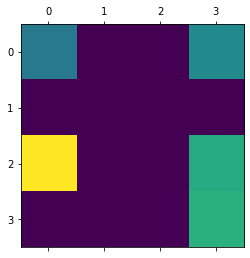

imgs/drowsy\drowsy6.jpg
1.0


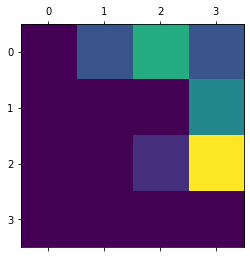

imgs/non-drowsy\non-drowsy8.jpg
1.0


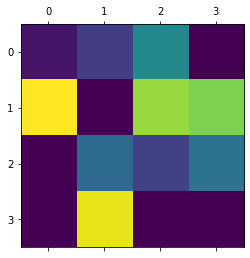

imgs/non-drowsy\non-drowsy6.jpg
1.0


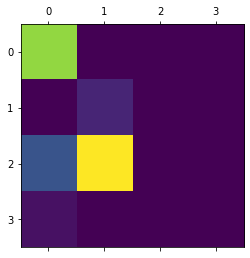

imgs/drowsy\drowsy8.jpg
1.0


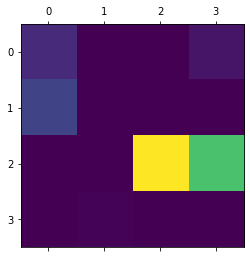

imgs/non-drowsy\non-drowsy2.jpg
1.0


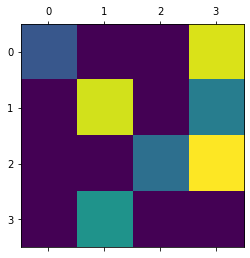

imgs/drowsy\drowsy4.jpg
1.0


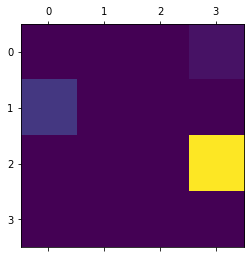

imgs/non-drowsy\non-drowsy4.jpg
1.0


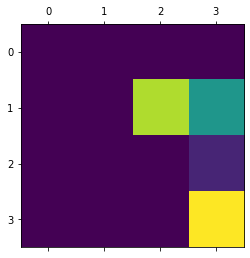

imgs/non-drowsy\non-drowsy1.jpg
1.0


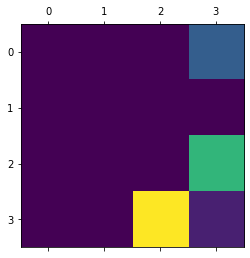

imgs/drowsy\drowsy1.jpg
1.0


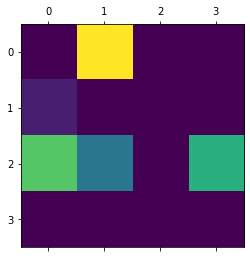

imgs/non-drowsy\non-drowsy5.jpg
1.0


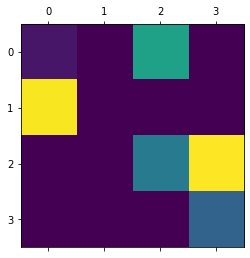

imgs/drowsy\drowsy7.jpg
1.0


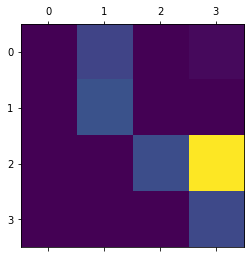

imgs/non-drowsy\non-drowsy3.jpg
1.0


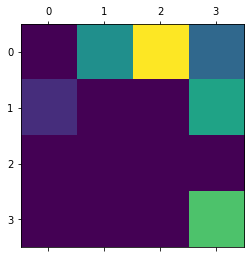

imgs/drowsy\drowsy5.jpg
1.0


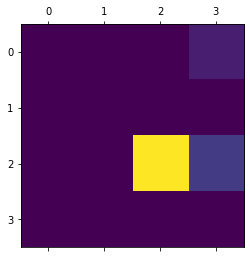

imgs/non-drowsy\non-drowsy7.jpg
1.0


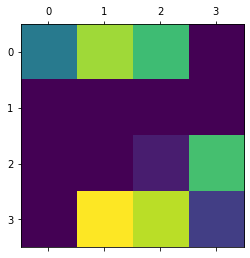

imgs/drowsy\drowsy2.jpg
1.0


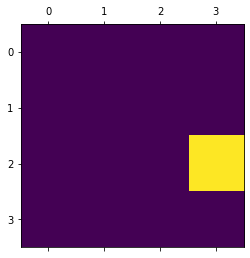

imgs/drowsy\drowsy3.jpg


In [19]:
# Prepare image
# img_array = preprocess_input(get_img_array("imgs/drowsy/drowsy1", size=(1,128,128,3)))

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = ImageWithNames(
    'imgs/',test_datagen,
    target_size=(128, 128),
    batch_size=16,
#     shuffle=True,
    class_mode='binary')
x_test_batch, fileNames = next(test_generator)
# print(recent_test_batch)
# x_test_batch = recent_test_batch[0]
# y_test_batch = recent_test_batch[1]

for i in range(len(x_test_batch)):
#     print(np.resize(x_test_batch[i],(128,128,3)).shape)
#     print(fileNames)
    # Print what the top predicted class is
    preds = test_step(np.expand_dims(x_test_batch[i],0))
    pred = np.reshape(tf.get_static_value(preds),(1,1))[0][0]
    print(pred)
    
    
    # Remove last layer's softmax
    model.layers[-1].activation = None
    
    # Generate class activation heatmap
#     img = np.resize(x_test_batch[i],(128,128,3))*255.0
    heatmap = make_gradcam_heatmap(tf.expand_dims(x_test_batch[i],0), model, 'conv2d_75')

    # Display heatmap
    plt.matshow(heatmap)
    plt.show()
    print(fileNames[i])
    actual = '0.0'
    if 'non-drowsy' in fileNames[i]:
        actual = '1.0'
    save_and_display_gradcam(fileNames[i],actual, pred, heatmap)
